In [184]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
%matplotlib widget

# Finding Pulse durations

2*pi-pulse: 17.9847 us
3/2*pi-pulse: 13.4885 us
pi-pulse: 8.9923 us
pi/2-pulse: 4.4962 us


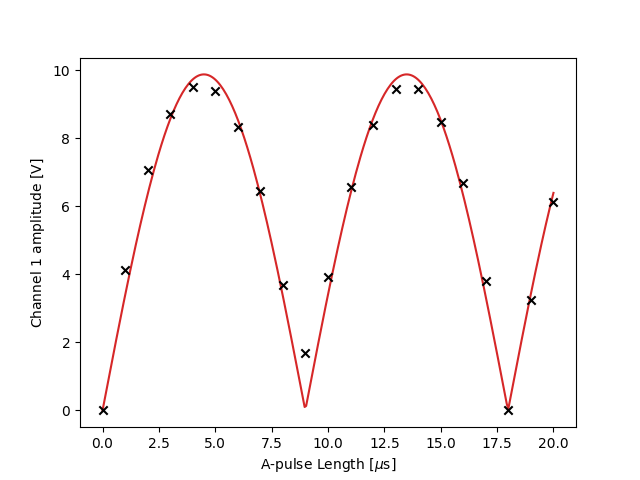

In [185]:
plt.close()
data = read_csv("Q1_measurements.csv", names=["A_length", 'c1', 'c2'])
data.drop(data.index[[0]], inplace=True)
data = data.astype(float)

data=data.values
x, c1, c2 = data[:, 0], data[:, 1], 1e-3 * data[:, 2]

fitX = np.linspace(min(x), max(x), 300)
# fitting c1
def absSinFit(x, amplitude, freq):
    return np.abs(amplitude * np.sin(freq*x))

initialguess = 10, 0.36
(amplitude, freq), _ = curve_fit(absSinFit, x, c1, initialguess)
plt.plot(fitX, absSinFit(fitX, amplitude, freq), color='C3')


plt.scatter(x, c1, marker='x', color="k", zorder=100)
plt.xlabel(r"A-pulse Length $[\mu\mathrm{s}]$")
plt.ylabel(r"Channel 1 amplitude $[\mathrm{V}]$")

plt.savefig("plots/channel1_pulselength", dpi=300, bbox_inches='tight', pad_inches=0.05)
print(f"2*pi-pulse: {2*np.pi / freq:.4f} us")
print(f"3/2*pi-pulse: {3/2*np.pi / freq:.4f} us")
print(f"pi-pulse: {np.pi / freq:.4f} us")
print(f"pi/2-pulse: {0.5*np.pi / freq:.4f} us")

/home/benjaminorthner/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


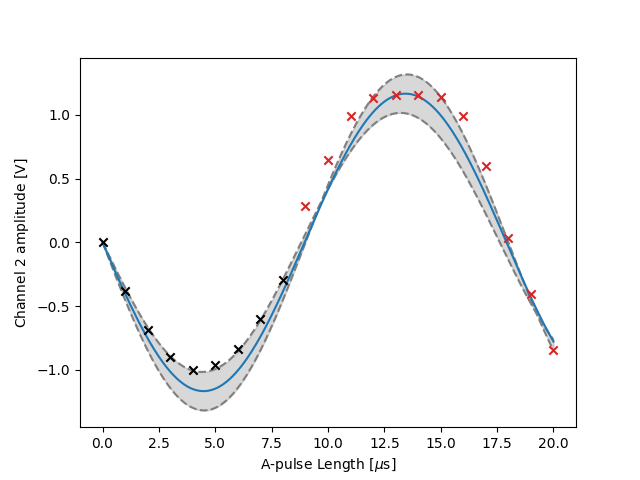

In [186]:
plt.close()


c2_trim0 = np.delete(c2, range(9,19))
x_trim0 = np.delete(x, range(9,19))

c2_trim1 = np.delete(c2, range(0,9))
x_trim1 = np.delete(x, range(0,9))

# fitting c2
def sinFit(x, amplitude, freq, shift):
    return amplitude * np.sin(freq*x  - np.pi)

initialguess = 1, 0.35, np.pi
(amplitude0, freq0, shift0), _ = curve_fit(sinFit, x_trim0, c2_trim0, initialguess)
plt.plot(fitX, sinFit(fitX, amplitude0, freq0, shift0), c='grey', linestyle="--", label="")

(amplitude1, freq1, shift1), _ = curve_fit(sinFit, x_trim1, c2_trim1, initialguess)
plt.plot(fitX, sinFit(fitX, amplitude1, freq1, shift1), c='grey', linestyle="--")

(amplitude, freq, shift), _ = curve_fit(sinFit, x, c2, initialguess)
plt.plot(fitX, sinFit(fitX, amplitude, freq, shift), c='C0', label="Fit to all")

plt.scatter(x[:9], c2[:9], marker='x', c='k', zorder=100)
plt.scatter(x[9:], c2[9:], marker='x', c='C3', zorder=100)
plt.fill_between(fitX, sinFit(fitX, amplitude0, freq0, shift0), sinFit(fitX, amplitude1, freq1, shift1), color="grey", alpha=0.3, zorder=-100)
#plt.grid()
plt.xlabel(r"A-pulse Length $[\mu\mathrm{s}]$")
plt.ylabel(r"Channel 2 amplitude $[\mathrm{V}]$")
plt.savefig("plots/channel2_pulselength", dpi=300, bbox_inches='tight', pad_inches=0.05)

M0: 8.149e+08 V
T2_star: 6.483e-07 ms


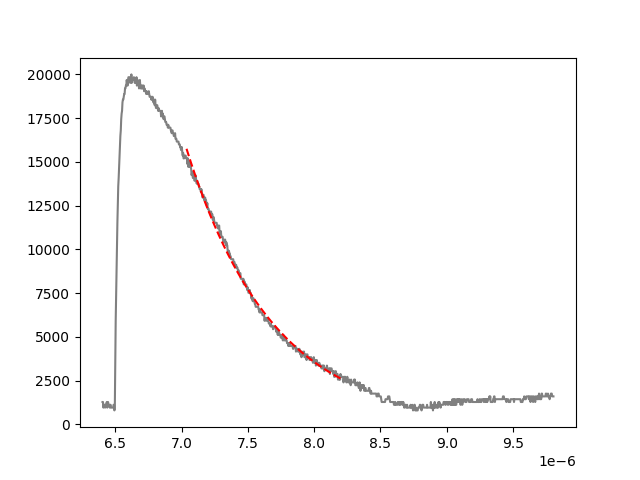

In [187]:
dataframe = read_csv("T2_stern_01.csv", names=["Tau","Volt"])    
dataframe.drop(dataframe.index[[0,1,2]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, y = data[2000:-1000, 0], data[2000:-1000, 1]

# adjust units
x *= 8e8 * 1e-12
y *= 2e6 * 1e-6

# Trim out noise and start from max + trim_front
trim_front = 130
trim_back = 500

maxindex = np.where(y == max(y))[0][0]
x_trim, y_trim = x[maxindex+trim_front:-trim_back], y[maxindex+trim_front:-trim_back]

# define the true function
def T2_function(t, M0, T2_star):
	return M0 * np.exp(-t / T2_star)

# Do the fit
initialguess = 1e7 *2 , 0.001 * (8e8 * 1e-12)
(M0, T2_star ), _ = curve_fit(T2_function, x_trim, y_trim, initialguess)

# Plot result
x_fit_line = np.linspace(min(x_trim), max(x_trim), num=1000)
y_fit_line = T2_function(x_fit_line, M0, T2_star)

plt.close()
plt.plot(x,y, c='gray')
plt.plot(x_fit_line, y_fit_line, '--', c='red')
print(f"M0: {M0:.3e} V\nT2_star: {T2_star:.3e} ms")

M0: 126.677266 V
T2_star: 0.827797 ms
xshift: 6.500970 ms
yshift: -0.067514 V


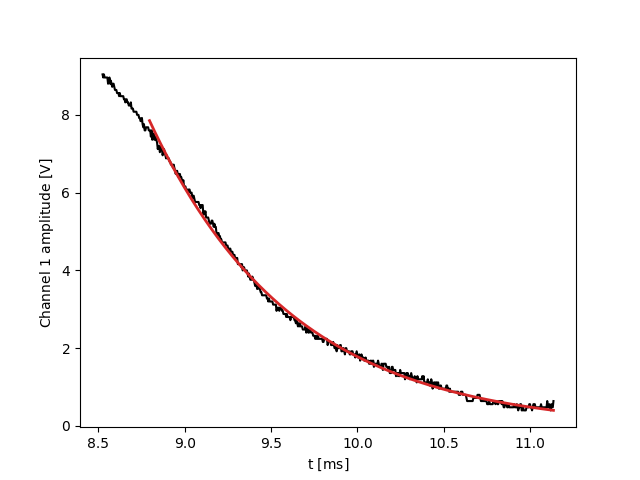

In [358]:
plt.close()
dataframe = read_csv("T2_stern_01.csv", names=["Tau","Volt"])    
dataframe.drop(dataframe.index[[0,1,2]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, y = data[2000:-1000, 0], data[2000:-1000, 1]

# shift max to t=0
#x -= 0.0085#x[np.argmax(y)]
# adjust minimum
#y -=  np.mean([y[i] for i in range(0, 20)])

# adjust units
x *= 1e3
y *= 1e-3

# Trim out noise and start from max + trim_front
trim_front = 130
trim_back = 280

maxindex = np.where(y == max(y))[0][0]
x_trim, y_trim = x[maxindex+trim_front:-trim_back], y[maxindex+trim_front:-trim_back]

# define the true function
def T2_function(t, M0, T2_star, xshift, yshift):
	return M0 * np.exp(-(t - xshift) / T2_star) + yshift

# Do the fit
initialguess = 10, 1, 0, 0
(M0, T2_star, xshift, yshift), _ = curve_fit(T2_function, x_trim, y_trim, initialguess)

# Plot result
x_fit_line = np.linspace(min(x_trim), max(x_trim), num=300)
y_fit_line = T2_function(x_fit_line, M0, T2_star, xshift, yshift)
plt.close()
plt.plot(x[trim_front:-trim_back],y[trim_front:-trim_back], c='black', linewidth=1.5)
plt.plot(x_fit_line, y_fit_line, '-', c='C3', linewidth=2)
print(f"M0: {M0:.6f} V\nT2_star: {T2_star:.6f} ms\nxshift: {xshift:.6f} ms\nyshift: {yshift:.6f} V")
plt.xlabel(r"t $[\mathrm{ms}]$")
plt.ylabel(r"Channel 1 amplitude $[\mathrm{V}]$")
plt.savefig("plots/T2_star", dpi=300, bbox_inches='tight', pad_inches=0.05)

# Finding $T_1$

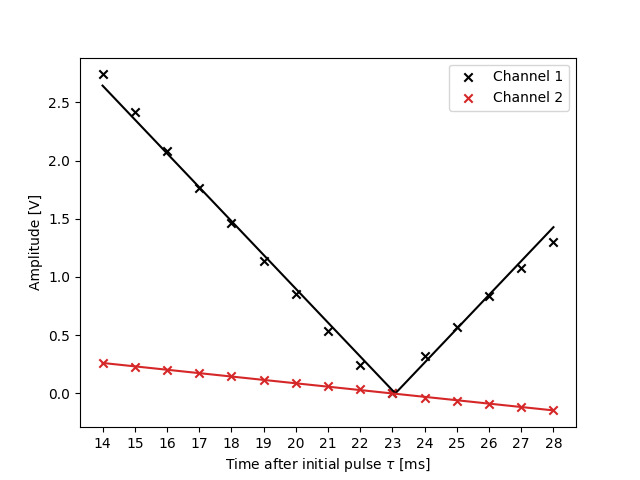

In [189]:
plt.close()
dataframe = read_csv("T1.csv", names=["Tau","VYellow", "VBlue"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, c1, c2 = data[:, 0], data[:, 1], data[:, 2]

def c1Fit(x, m, c):
    if c < 0:
        return 10000
    return np.abs(m * x + c)

def c2Fit(x, m, c):
    return m * x + c

guess1 = -0.4, 9
guess2 = -0.1, 0.3

(mFit1, cFit1), _ = curve_fit(c1Fit, x, c1, guess1)
(mFit2, cFit2), _ = curve_fit(c2Fit, x, c2, guess2)

xFit = np.linspace(min(x), max(x), 300)
plt.plot(xFit, c1Fit(xFit, mFit1, cFit1), c='k')
plt.plot(xFit, c2Fit(xFit, mFit2, cFit2), c='C3')
    
plt.scatter(x, c1, marker = 'x', color="k", label="Channel 1")
plt.scatter(x, c2, marker='x', color="C3", label="Channel 2")
plt.legend()
plt.ylabel("Amplitude [V]")
plt.xlabel(r"Time after initial pulse $\tau$ [ms]")
#plt.grid()
plt.xticks(np.arange(14,29,1), np.arange(14,29,1))
plt.savefig("plots/findingT1", dpi=300, bbox_inches='tight', pad_inches=0.05)

# $T_2^*$ vs $T_2$

M0: 8.878 V
T2: 11.142 ms


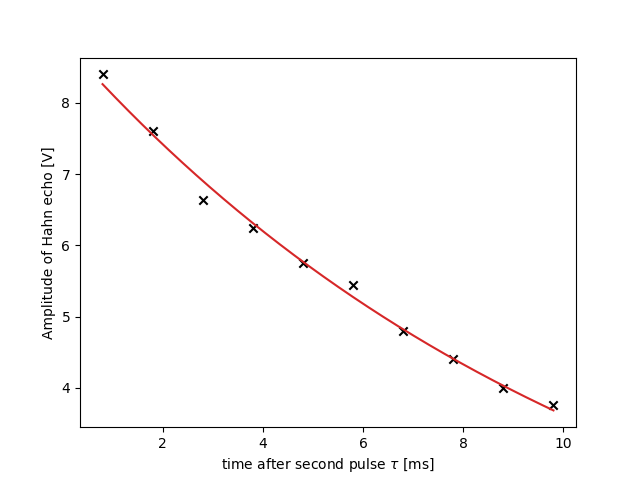

In [305]:
plt.close()
dataframe = read_csv("T2_star_vs_T2.csv", names=["Tau","V_abs", "V_pure"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
x, yAbs, yPure = data[:, 0], data[:, 1], data[:, 2]


# define the true function
def T2_function(t, M0, T2):
	return M0 * np.exp(-t / T2)

# Do the fit
initialguess = 1, 1
(M0, T2 ), _ = curve_fit(T2_function, x, yAbs, initialguess)

# Plot result
x_fit_line = np.linspace(min(x), max(x), num=1000)
y_fit_line = T2_function(x_fit_line, M0, T2)

plt.scatter(x, yAbs, marker='x', c='k', label="Absolute Amplitude")
#plt.scatter(x, yPure, marker = 'x', label="Relative Amplitude")
plt.plot(x_fit_line, y_fit_line, '-', c='C3', label=r"$V = M_0 e^{-t / T_2}$")

#plt.ylim(0, 9)
#plt.xlim(0, 10)
plt.ylabel("Amplitude of Hahn echo [V]")
plt.xlabel(r"time after second pulse $\tau$ [ms]")

print(f"M0: {M0:.3f} V\nT2: {T2:.3f} ms")
plt.savefig("plots/T2.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

In [359]:
gamma = 267.522e6
T2_star = 0.82779e-3
T2 = 11.142e-3
B= -2/gamma * (1/T2 - 1/T2_star)
print(f"{B:.10e}")

8.3603244658e-06


# MG On/Off

34.88


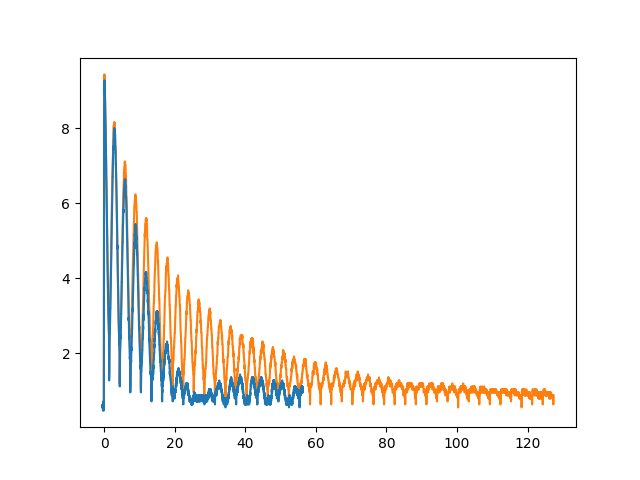

In [289]:
plt.close()
dataframeOn = read_csv("MultiplePulses_MG_ON.csv", names=["Tau","Volt"])    
dataframeOn.drop(dataframeOn.index[[0,1,2]], inplace=True)
dataframeOn = dataframeOn.astype(float)

dataframeOff = read_csv("MultiplePulses_MG_OFF.csv", names=["Tau","Volt"])    
dataframeOff.drop(dataframeOff.index[[0,1,2]], inplace=True)
dataframeOff = dataframeOff.astype(float)

xOff, yOff = 1e3*dataframeOff.values[1228:, 0], 1e-3*dataframeOff.values[1228:, 1]
xOn, yOn = 1e3*dataframeOn.values[871:, 0], 1e-3*dataframeOn.values[871:, 1]

peaksOn = find_peaks(yOn, threshold=0, distance=50)[0]
peaksOff = find_peaks(yOff, threshold=0, distance=50)[0]

print(xOn[0])
xOn -= xOn[peaksOn[0]]
xOff -= xOff[peaksOff[0]]
plt.plot(xOff, yOff)
plt.plot(xOn, yOn, zorder=-1)

a: 7.916272V 
T2: 20.953157 ms
offset: 1.218976 V


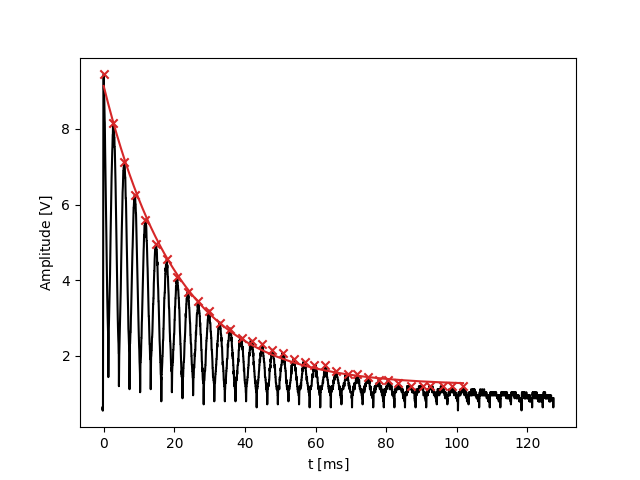

In [318]:
plt.close()
# Find peaks (needed to plot envelope)
peaksOn = find_peaks(yOn, threshold=0, distance=50)[0]

xPeakOn = [xOn[i] for i in peaksOn][:-10]
yPeakOn = [yOn[i] for i in peaksOn][:-10]

plt.plot(xOn, yOn, c="k")
plt.scatter(xPeakOn, yPeakOn, c="C3", marker="x", zorder=101)

def exp_function(x, a, T2, offset):
    return a*np.exp(-x / (T2)) + offset

# Do the fit
initialguess = 9, 20, 2
(a, T2, offset), _ = curve_fit(exp_function, xPeakOn, yPeakOn, initialguess)

# Plot result
x_fit_line = np.linspace(min(xPeakOn), max(xPeakOn), num=1000)
y_fit_line = exp_function(x_fit_line, a, T2, offset)

plt.plot(x_fit_line, y_fit_line, '-', c='C3', zorder=100)

print(f"a: {a:f}V \nT2: {T2 :f} ms\noffset: {offset:f} V")
plt.xlabel(r"t $[\mathrm{ms}]$")
plt.ylabel(r"Amplitude $[\mathrm{V}]$")
plt.savefig("plots/mgOn", dpi=300, bbox_inches='tight', pad_inches=0.05)
    

a: 8.948117 V
T2: 10.610862 ms
offset: 0.930632 V


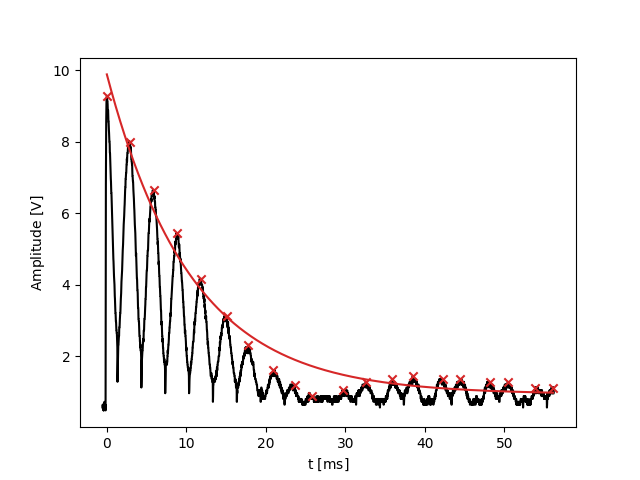

In [324]:
plt.close()
peaksOff = find_peaks(yOff, threshold=0, distance=100)[0]

xPeakOff = [xOff[i] for i in peaksOff][0:]
yPeakOff = [yOff[i] for i in peaksOff][0:]

plt.plot(xOff, yOff, c="k")
plt.scatter(xPeakOff, yPeakOff, c="C3", marker="x", zorder=101)

# Do the fit
initialguess = 9, 10, 1
(a, T2, offset), _ = curve_fit(exp_function, xPeakOff, yPeakOff, initialguess)

# Plot result
x_fit_line = np.linspace(min(xPeakOff), max(xPeakOff), num=1000)
y_fit_line = exp_function(x_fit_line, a, T2, offset)

plt.plot(x_fit_line, y_fit_line, '-', c='C3')

print(f"a: {a:f} V\nT2: {T2:f} ms\noffset: {offset:f} V")
plt.xlabel(r"t $[\mathrm{ms}]$")
plt.ylabel(r"Amplitude $[\mathrm{V}]$")
    
plt.savefig("plots/mgOff", dpi=300, bbox_inches='tight', pad_inches=0.05)